## CLIMB Deconvolution - In-Vitro dataset

CLIMB infers cell-subtype proportions through a linear combination of single-cell expression. By aggregating coefficients by cell subtype, it predicts the composition of a cell mix. We generated in vitro pools containing various ratios of HL60, SUDHL4, K562, and THP1 human leukemic cells. We could thus use these pre-determined ratios as ground truth to compare the predictive value of CLIMB and a panel of published bulk deconvolution methods: BayesPrism, CiberSortX, MUSIC, BisqueRNA, and NNLS, using random proportions as a negative control.

*Note: As CiberSortX deconvolution was obtained via their website interface, we use here the table containing the processed results of cell line proportions.*


In [22]:
library(ggplot2) ; library(glmnet) ; library(Biobase)
library(reshape2) ; library(ggpubr); library(SingleCellExperiment)
library(ComplexHeatmap) ; library(circlize) ; library(RColorBrewer)
library(cocor) ; library(ggpmisc)

# load CLIMB and MUSIC
library(MuSiC) ; library(climb) 

## Load data

We load the data stored as `ExpressionSet` object (library `xbioc` required). We will load the scRNA-seq reference dataset in the object `sc.es` and the bulk RNA-seq from six mixtures in `bulk.es`. 

In [3]:
# Load ExpressionSet object containing scRNA-seq data from in-vitro cell mixes
sc.es = readRDS("data/invitro_climb2/invitro_sc_es.RDS")
dim(sc.es)

Warning message in gzfile(file, "rb"):
“cannot open compressed file 'data/invitro_climb2/invitro_sc_es.RDS', probable reason 'No such file or directory'”


ERROR: Error in gzfile(file, "rb"): cannot open the connection


2342 cells were sequenced and 6169 genes kept after filtering low counts with default Seurat pipeline 

In [4]:
# Load ExpressionSet object containing bulk RNA-seq data from in-vitro cell mixes
bulk.es = readRDS("data/invitro_climb2/invitro_bulk_es_raw.RDS")
dim(bulk.es)

Features  Samples 
    6169        6

6 mixtures of cell lines with expression from 6169 genes

In [5]:
# Load True cell line proportions (based on the volume of homogeneised cells pippeted in the mixture)
true_prop = as.matrix(pData(bulk.es))
true_prop

,HL60,K562,SUDHL4,THP1
BULK1,0.2600,0.0900,0.3300,0.3200
BULK2,0.5700,0.1100,0.0700,0.2500
BULK3,0.3333,0.2222,0.0000,0.4444
BULK4,0.0500,0.0400,0.6100,0.3000
BULK5,0.0198,0.3168,0.1881,0.4752
BULK6,0.1200,0.2600,0.2000,0.4200


### Functions 

In [23]:
# METRICS FUNCTIONS
num <- function(x){ return(as.numeric(as.character(x)))}
flatten <- function(x){return(as.vector(as.matrix(x)))}
mse <- function(tr, pr){ return( sum((tr - pr)^2) / length(tr) ) }
rmse <- function(tr, pr){ return( sqrt( sum((tr - pr)^2) / length(tr) ) ) }
scor <- function(tr, pr){ return( cor(tr, pr, method = 'spearman') ) }
pcor <- function(tr, pr){ return( cor(tr, pr, method = 'pearson') ) }
r_square <- function(pr, tr){ return( sign(cor(pr,tr)) * cor(pr,tr)^2 ) }
### Function to retrieve all metrics from Deconvolution vs True cell-type proportion comparison
comp_rows_and_cols <- function(pred_prop, true_prop){
    pc_l = list() ; sc_l = list()
    rsq_l = list(); rmse_l = list()
    # per row metrics:
    for(i in 1:dim(pred_prop)[1]){
        pc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'pearson')
        sc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'spearman')
        rsq_l[[i]] = max(r_square(pred_prop[i,], true_prop[i,]), -1.0)
        rmse_l[[i]] = rmse(pred_prop[i,], true_prop[i,])
    }
    pc_c = list() ; sc_c = list()
    rsq_c = list(); rmse_c = list()
    # per-column metrics:
    for(i in 1:dim(pred_prop)[2]){
        pc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'pearson')
        sc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'spearman')
        rsq_c[[i]] = max(r_square(pred_prop[,i], true_prop[,i]), -1.0)
        rmse_c[[i]] = rmse(pred_prop[,i], true_prop[,i])
    }
    res = list() ; 
    res[[1]] = num(pc_l) ; res[[2]] = num(sc_l)
    res[[3]] = num(rsq_l); res[[4]] = num(rmse_l)
    res[[5]] = num(pc_c) ; res[[6]] = num(sc_c)
    res[[7]] = num(rsq_c); res[[8]] = num(rmse_c)
    # overall metrics:
    res[[9]] = pcor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[10]] = scor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[11]] = max(r_square(as.vector(num(pred_prop)), as.vector(num(true_prop))), -1.0)
    res[[12]] = rmse(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    return(res)
}

## Load pre-processed Deconvolution results

Here is the results of diverse deconvolution methods, to be loaded to reproduce same results as in the manuscripts, and to be compared with results obtained by CLIMB which we will run below. 

NNLS proportions for certain cell lines have columns constituted of zero only. These returns the warning message 'the standard deviation is zero'.

In [7]:
in_dir_proc_dat = 'data/climb_props_tabs/'
# CiberSortX
csx_prop = read.csv(paste0(in_dir_proc_dat,'cibersortx_prop.csv'), row.names = "Mixture")[,seq(1,4)]
csx_prop = as.matrix(csx_prop[,match(colnames(true_prop), colnames(csx_prop))])
csx.res = comp_rows_and_cols(csx_prop, true_prop)
# BayesPrism
bayesprism_prop = as.matrix(read.csv(paste0(in_dir_proc_dat,'bayesprism_prop.csv'), row.names = 'X'))
bayesprism.res = comp_rows_and_cols(bayesprism_prop, true_prop)
# MUSIC
music_prop = as.matrix(read.csv(paste0(in_dir_proc_dat,'music_prop.csv'), row.names = 'X'))
music.res = comp_rows_and_cols(music_prop, true_prop)
# NNLS
nnls_prop = as.matrix(read.csv(paste0(in_dir_proc_dat,'nnls_prop.csv'), row.names = 'X'))
nnls.res = comp_rows_and_cols(nnls_prop, true_prop)
# BisqueRNA
bisque_prop = as.matrix(read.csv(paste0(in_dir_proc_dat,'bisque_prop.csv'), row.names = 'X'))
bisque.res = comp_rows_and_cols(bisque_prop, true_prop)
# Scaden 
scaden_prop = read.csv(paste0(in_dir_proc_dat,'Scaden_prop.csv'), row.names = 'X')
scaden.res = comp_rows_and_cols(as.matrix(scaden_prop), as.matrix(true_prop))
# TAPE 
tape_prop = read.csv(paste0(in_dir_proc_dat,'tape_prop.csv'), row.names = 'X')
tape.res = comp_rows_and_cols(as.matrix(tape_prop), as.matrix(true_prop))
# Random 
rand_prop = read.csv(paste0(in_dir_proc_dat,'rand_prop.csv'), row.names = 'X')
rand.res = comp_rows_and_cols(as.matrix(rand_prop), as.matrix(true_prop))

Warning message in file(file, "rt"):
“cannot open file 'data/climb_props_tabs/cibersortx_prop.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [97]:
# Verify column ordering
all(colnames(true_prop) == colnames(bayesprism_prop) & colnames(true_prop) == colnames(music_prop) &
    colnames(true_prop) == colnames(music_prop)      & colnames(true_prop) == colnames(nnls_prop) &
    colnames(true_prop) == colnames(bisque_prop)     & colnames(true_prop) == colnames(scaden_prop) & 
    colnames(true_prop) == colnames(tape_prop))
# Verify row ordering
all(rownames(true_prop) == rownames(bayesprism_prop) & rownames(true_prop) == rownames(music_prop) &
    rownames(true_prop) == rownames(music_prop)      & rownames(true_prop) == rownames(nnls_prop) &
    rownames(true_prop) == rownames(bisque_prop)     & rownames(true_prop) == rownames(scaden_prop) & 
    rownames(true_prop) == rownames(tape_prop))

[1] TRUE

[1] TRUE

## CLIMB deconvolution of bulk samples
Here we launch CLIMB deconvolution with default settings to predict cell type abundance

In [234]:
write.csv(exprs(sc.es), 'data/invitro/invitro_sc_es_mat.csv', quote=F)

In [236]:
write.csv(sc.es$cellType, 'data/invitro/invitro_sc_es_cellType.csv', quote=F)

In [235]:
write.csv(exprs(bulk.es), 'data/invitro/invitro_bulk_es_mat.csv', quote=F)

In [213]:
climb_out = climb(sc.es, bulk.es, mode='abundance', norm_coefs = T) # norm_coefs = F to reproduce results
climb_prop = climb_out$props

ABUNDANCE mode: predicting cell-type proportions in bulks

6169 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance

Cell-type abundance prediction done. 



In [214]:
# Display the Pearson correlation coefficient considering all 24 dots (6 mixtures with 4 cell lines)
cor(flatten(true_prop), flatten(climb_prop))

[1] 0.9428947

In [215]:
climb_out = climb2(sc.es, bulk.es, mode='abundance', norm_coefs = T) # norm_coefs = F to reproduce results
climb_prop2 = climb_out$props

ABUNDANCE mode: predicting cell-type proportions in bulks

6169 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance

Cell-type abundance prediction done. 



In [216]:
# Display the Pearson correlation coefficient considering all 24 dots (6 mixtures with 4 cell lines)
cor(flatten(true_prop), flatten(climb_prop2))

[1] 0.9433385

In [226]:
library(matlib)

In [229]:
C = exprs(sc.es)
y = exprs(bulk.es)[,1]

In [230]:
fit <- lm(y ~ C)

No id variables; using all as measure variables

No id variables; using all as measure variables



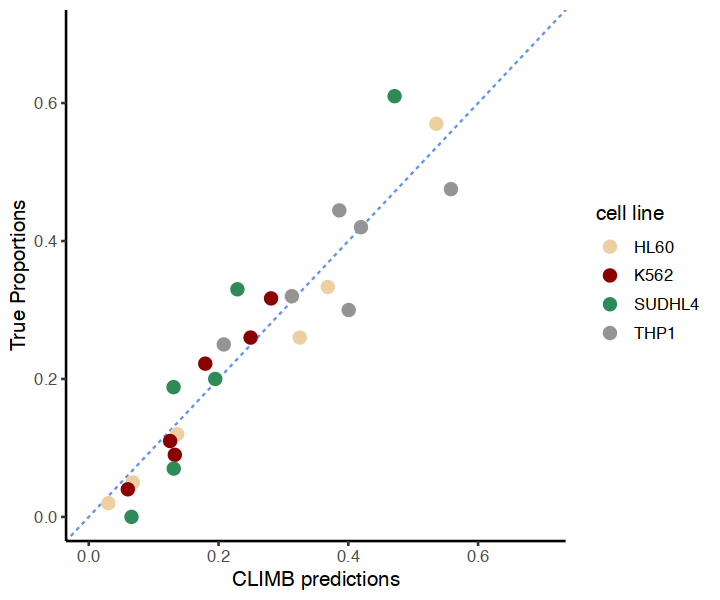

In [54]:
# Plot and display the results 
options(repr.plot.width=6, repr.plot.height=5)
df_cor = cbind(reshape2::melt(data.frame(true_prop)), 
               reshape2::melt(data.frame(climb_prop)))
colnames(df_cor) = c('cell line', 'True Proportions', 'x', 'CLIMB predictions')
g = ggplot(df_cor) + geom_abline(slope=1, linetype = "dashed", colour='cornflowerblue') + 
    geom_point(aes(y=`True Proportions`, x=`CLIMB predictions`, colour=`cell line`), size=3) + theme_classic2() + 
    #stat_poly_eq(aes(y=`True Proportions`, x=`CLIMB predictions`)) + 
    scale_color_manual(values=c('navajowhite2',  'darkred', 'seagreen', 'grey58')) +
    ylab('True Proportions') + xlab('CLIMB predictions') + xlim(0,0.7) + ylim(0,0.7)
#pdf("results/climb_invitro/figs/invitro_CLIMB_2d.pdf", width=4, height=3) ; g ; dev.off()
g

In [29]:
climb.res = comp_rows_and_cols(climb_prop, true_prop)

In [50]:
# pearson correlation per samples (6 values)
print(median(unlist(climb.res[1])))
climb.res[1]

[1] 0.9658729


[[1]]
[1] 0.7497600 0.9860816 0.9600819 0.9368870 0.9716639 0.9964733

### Coefficient normalization per cell's total expression

Reviewer #3 ran CLIMB without coefficient normalization (norm_coefs=F), here is the reproduced results:

In [51]:
# if we re-run CLIMB with norm_coefs = F, we get the following:
climb_out2 = climb(sc.es, bulk.es, mode='abundance', norm_coefs = F) # norm_coefs = F to reproduce results
climb_prop2 = climb_out2$props
climb.res2 = comp_rows_and_cols(climb_prop2, true_prop)
# pearson correlation per samples (6 values)
print(median(unlist(climb.res2[1])))
climb.res2[1]

ABUNDANCE mode: predicting cell-type proportions in bulks

6169 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance

Cell-type abundance prediction done. 



[1] 0.8967051


[[1]]
[1] -0.02086949  0.90383830  0.88957195  0.98319386  0.90798565  0.66692194

which corresponds to the results obtained by reviewer #3

## Fig. 2B

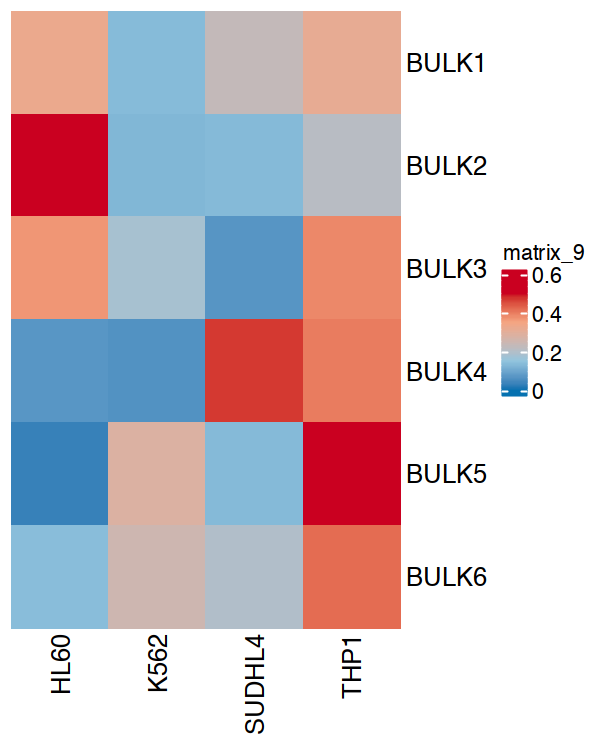

In [167]:
rownames(climb_prop) = rownames(true_prop)
options(repr.plot.width=4, repr.plot.height=5, repr.plot.res=150)
col_fun = colorRamp2(c(0, 0.15, 0.35, 0.5), rev(brewer.pal(4,"RdBu"))) # we use the same color breaks for both heatmap
h_climb <- Heatmap(climb_prop, col=col_fun, cluster_rows = F, cluster_columns = F, show_row_dend = F, show_column_dend = F)
h_climb

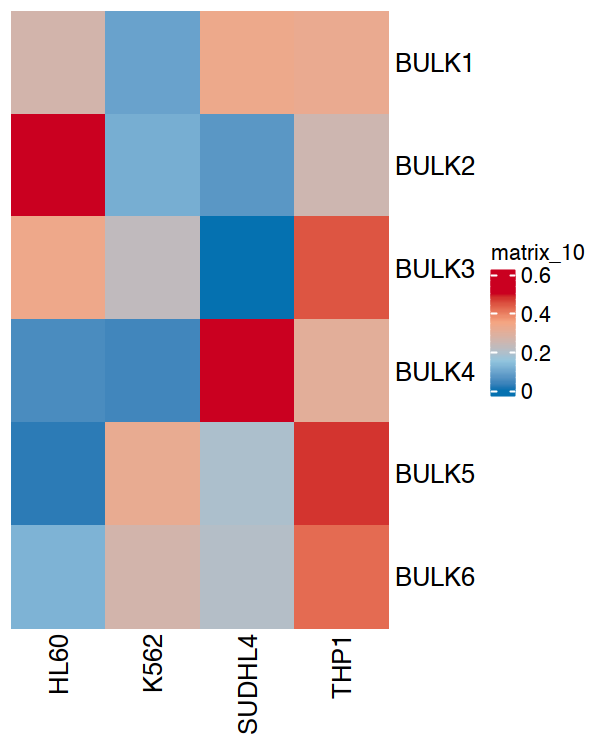

In [168]:
options(repr.plot.width=4, repr.plot.height=5, repr.plot.res=150)
h_true <- Heatmap(true_prop, col=col_fun, cluster_rows = F,  cluster_columns = F, show_row_dend = F, show_column_dend = F)
h_true

## BayesPrism Deconvolution

We provide here the code used to run BayesPrism. Unfortunately we did not manage to install it on Renku.

In [52]:
# Code used to run BayesPrism (BayesPrism could not be)
#myPrism <- new.prism(reference= t(exprs(sc.es)), 
#                     mixture=t(exprs(bulk.es)), input.type="count.matrix", 
#                     cell.type.labels = as.character(sc.es$cellType), 
#                     cell.state.labels = as.character(sc.es$cellType), 
#                     key = NULL,outlier.cut=0.01,outlier.fraction=0.1)
#bp.res <- run.prism(prism = myPrism, n.cores=6)
#bayesprism_prop <- get.fraction (bp=bp.res, which.theta="final",
#             state.or.type="type")
#bayesprism_prop = bayesprism_prop[,match(colnames(true_prop), colnames(bayesprism_prop))]

No id variables; using all as measure variables

No id variables; using all as measure variables



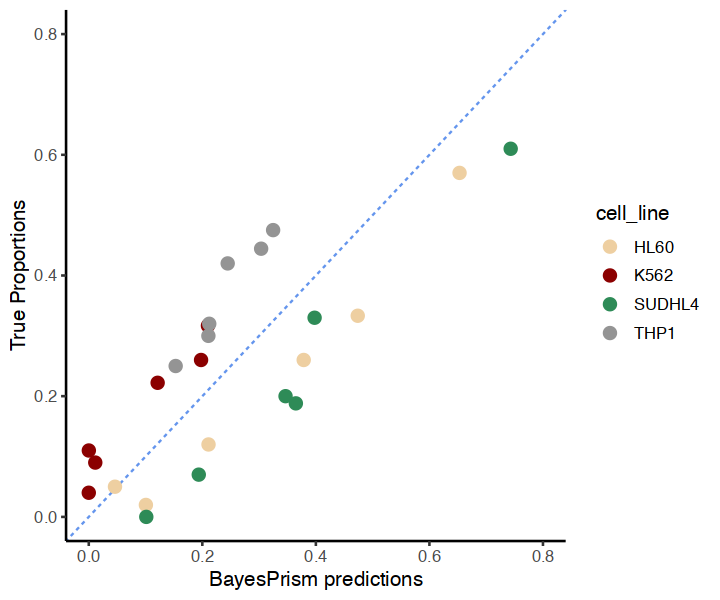

In [56]:
df_msc = cbind(reshape2::melt(data.frame(true_prop)), 
               reshape2::melt(data.frame(bayesprism_prop)))
colnames(df_msc) = c('cell_line', 'true.prop', 'x', 'bayesprism_prop')
g = ggplot(df_msc) + geom_abline(slope=1, linetype = "dashed", colour='cornflowerblue') + 
    geom_point(aes(x=bayesprism_prop, y=true.prop, colour=cell_line), size=3) + theme_classic2() + 
    #stat_poly_eq(aes(x=bayesprism_prop, y=true.prop)) + 
    scale_color_manual(values=c('navajowhite2',  'darkred', 'seagreen', 'grey58')) +
    ylab('True Proportions') + xlab('BayesPrism predictions')  + xlim(0,0.8) + ylim(0,0.8)
#pdf("results/climb_invitro/figs/invitro_BayesPrism_2d.pdf", width=4, height=3) ; g ; dev.off()
g

## MuSiC Deconvolution

We will run here MuSiC deconvolution, which is also use to derive NNLS predictions.

In [63]:
sce <- SingleCellExperiment(list(counts=exprs(sc.es)),
                            colData=DataFrame(label=colnames(sc.es),
                                              cellType=sc.es$cellType,
                                              SubjectName=sc.es$SubjectName),
                            rowData=DataFrame(gene_name=rownames(sc.es)))
# Estimate cell type proportions
music.output = music_prop(bulk.mtx = exprs(bulk.es), 
                             sc.sce = sce, 
                             clusters = 'cellType',
                             samples = 'SubjectName',
                             verbose = T)
music_prop = music.output$Est.prop.weighted

Creating Relative Abudance Matrix...

Creating Variance Matrix...

Creating Library Size Matrix...

Used 6169 common genes...

Used 4 cell types in deconvolution...

BULK1 has common genes 6164 ...

BULK2 has common genes 6166 ...

BULK3 has common genes 6143 ...

BULK4 has common genes 6107 ...

BULK5 has common genes 6158 ...

BULK6 has common genes 6167 ...



In [64]:
music_prop = music_prop[,match(colnames(true_prop), colnames(music_prop))]

In [65]:
cor(as.vector(music_prop), as.vector(true_prop))

[1] 0.751353

In [ ]:
music.output

No id variables; using all as measure variables

No id variables; using all as measure variables



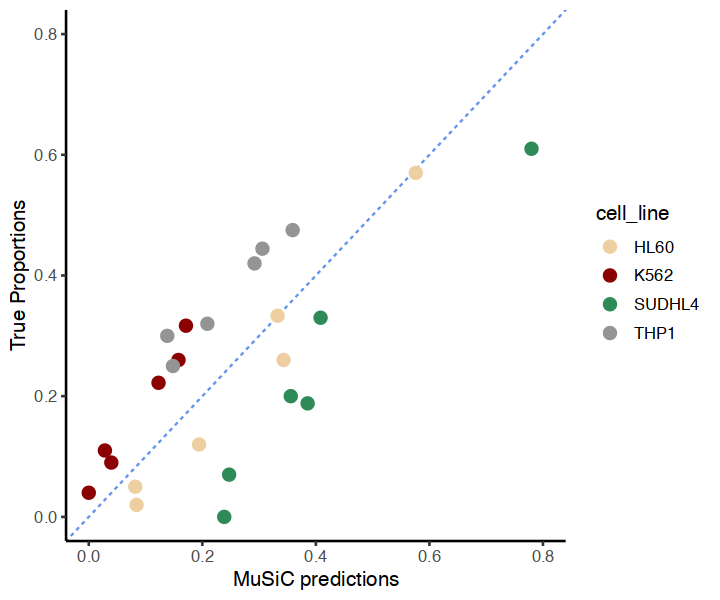

In [66]:
df_msc = cbind(reshape2::melt(data.frame(true_prop)), 
               reshape2::melt(data.frame(music_prop)))
colnames(df_msc) = c('cell_line', 'true.prop', 'x', 'MuSiC.prop')
g = ggplot(df_msc) + geom_abline(slope=1, linetype = "dashed", colour='cornflowerblue') + 
    geom_point(aes(y=true.prop, x=MuSiC.prop, colour=cell_line), size=3) + theme_classic2() + 
    scale_color_manual(values=c('navajowhite2',  'darkred', 'seagreen', 'grey58')) +
    #stat_poly_eq(aes(y=true.prop, x=MuSiC.prop)) + 
    ylab('True Proportions') + xlab('MuSiC predictions') + xlim(0,0.8) + ylim(0,0.8)
#pdf("results/climb_invitro/figs/invitro_MUSIC_2d.pdf", width=4, height=3) ; g ; dev.off()
g

### NNLS Deconvolution

The NNLS proportions are derived from MUSIC output, as stated in the original publications and in the MUSIC tutorial [ref]. 

In [73]:
# NNLS estimation is found in the output of MUSIC deconvolution 
nnls_prop = music.output$Est.prop.allgene
nnls_prop = nnls_prop[,match(colnames(true_prop), colnames(nnls_prop))]

In [74]:
# check column / row names : 
all(colnames(true_prop) == colnames(nnls_prop))  
all(rownames(true_prop) == rownames(nnls_prop))

[1] TRUE

[1] TRUE

In [75]:
cor(as.vector(nnls_prop), as.vector(true_prop))

[1] -0.03215219

### BisqueRNA 


In [76]:
#bisque.res = BisqueRNA::ReferenceBasedDecomposition(bulk.es, sc.es, use.overlap=F)
#res.prop = data.frame(t(bisque.res$bulk.props))

In [78]:
# Display the Pearson correlation coefficient considering all 24 dots (6 mixtures with 4 cell lines)
cor(as.vector(as.matrix(true_prop)), as.vector(as.matrix(bisque_prop)))

[1] 0.02402223

No id variables; using all as measure variables

No id variables; using all as measure variables



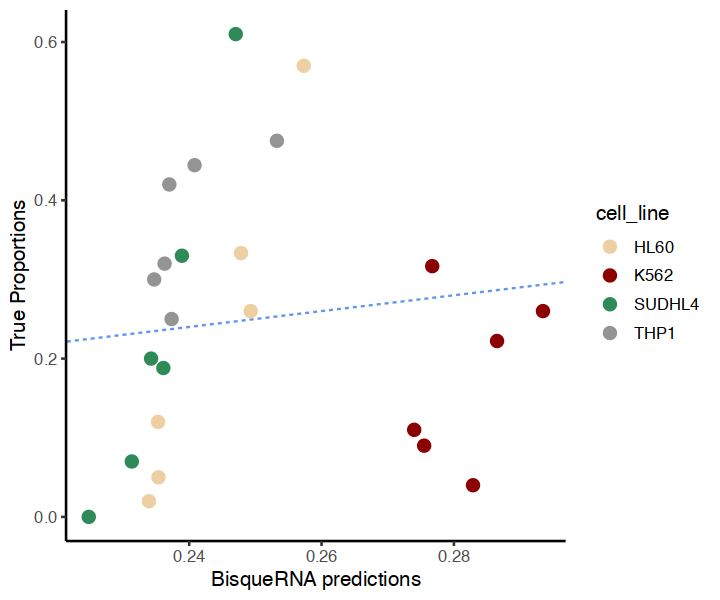

In [79]:
df_cor = cbind(reshape2::melt(data.frame(true_prop)), 
               reshape2::melt(data.frame(bisque_prop[1:6,])))
colnames(df_cor) = c('cell_line', 'true.prop', 'x', 'Bisque.pred')
g = ggplot(df_cor) + geom_abline(slope=1, linetype = "dashed", colour='cornflowerblue') + 
    geom_point(aes(y=true.prop, x=Bisque.pred, colour=cell_line), size=3) + theme_classic2() + 
    #stat_poly_eq(aes(y=true.prop, x=Bisque.pred)) + 
    scale_color_manual(values=c('navajowhite2',  'darkred', 'seagreen', 'grey58')) +
    ylab('True Proportions') + xlab('BisqueRNA predictions')
#pdf("results/climb_invitro/figs/invitro_BisqueRNA_2d.pdf", width=4, height=3) ; g ; dev.off()
g

## CiberSortX Deconvolution 

As CSX was run on the CSX website, we directly load the ouput. CSX was ran with all default settings.

In [80]:
cor(as.vector(csx_prop), as.vector(true_prop))

[1] 0.7308551

No id variables; using all as measure variables

No id variables; using all as measure variables



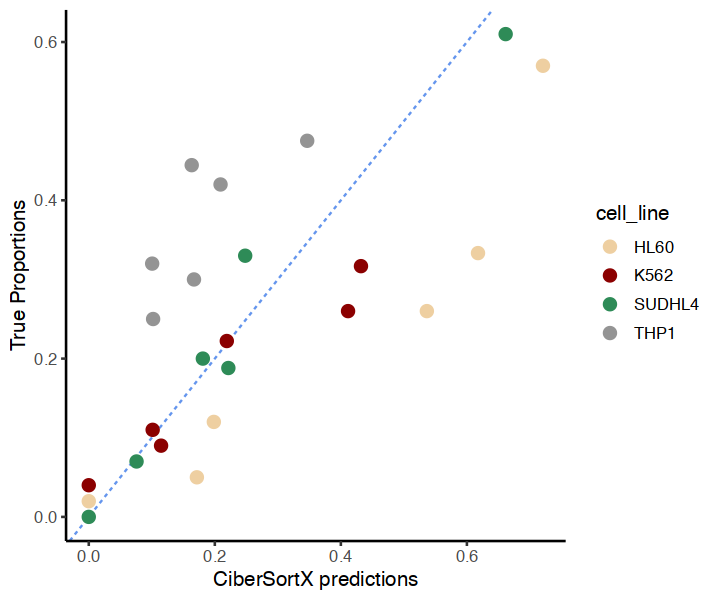

In [81]:
df_msc = cbind(reshape2::melt(data.frame(true_prop)), 
               reshape2::melt(data.frame(csx_prop)))
colnames(df_msc) = c('cell_line', 'true.prop', 'x', 'csx_props')
g = ggplot(df_msc) + geom_abline(slope=1, linetype = "dashed", colour='cornflowerblue') + 
    geom_point(aes(y=true.prop, x=csx_props, colour=cell_line), size=3) + theme_classic2() + 
    #stat_poly_eq(aes(y=true.prop, x=csx_props)) + 
    scale_color_manual(values=c('navajowhite2',  'darkred', 'seagreen', 'grey58')) +
    ylab('True Proportions') + xlab('CiberSortX predictions')
#pdf("results/climb_invitro/figs/invitro_CiberSortX_2d.pdf", width=4, height=3) ; g ; dev.off()
g

## Write table for TAPE method 

TAPE is a python method that can be run through another notebook `rev_TAP_launch.ipynb`. The package is not working on Renku but TAPE/Scaden methods can both be installed pretty easily and ran through our notebook script if needed.

In [580]:
# This is the code to generate the input data for TAPE: 
#write.csv(t(exprs(bulk.es)), "data/celltype_expression/TAPE/input/invitro_bulk.csv", quote=F)
#sc_mat_TAPE = exprs(sc.es)
#sc_mat_TAPE = t(sc_mat_TAPE)
#rownames(sc_mat_TAPE) = sc.es$cellType
#write.csv(sc_mat_TAPE, "data/celltype_expression/TAPE/input/invitro_sc_mat.csv", quote=F)

In [82]:
cor(as.vector(as.matrix(tape_prop)), as.vector(as.matrix(true_prop)))

[1] 0.6231752

No id variables; using all as measure variables

No id variables; using all as measure variables

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


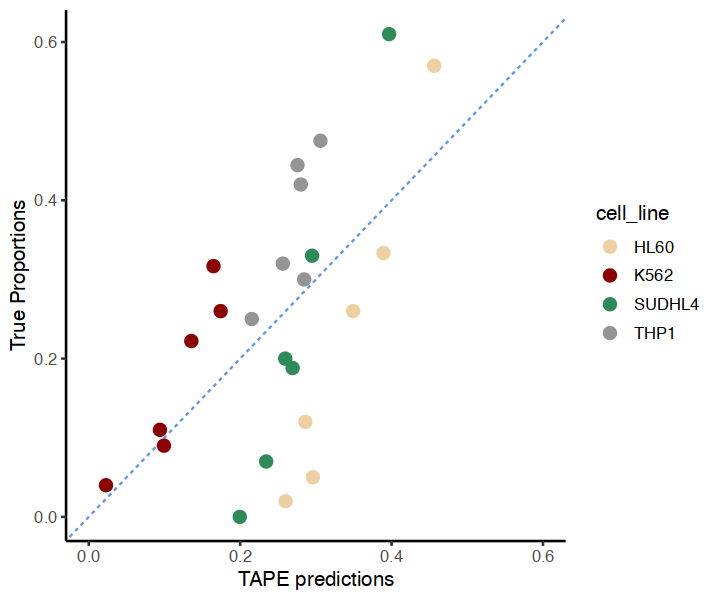

In [83]:
df_msc = cbind(reshape2::melt(data.frame(true_prop)), 
               reshape2::melt(data.frame(tape_prop)))
colnames(df_msc) = c('cell_line', 'true.prop', 'x', 'tape_prop')
g = ggplot(df_msc) + geom_abline(slope=1, linetype = "dashed", colour='cornflowerblue') + 
    geom_point(aes(y=true.prop, x=tape_prop, colour=cell_line), size=3) + theme_classic2() + 
    #stat_poly_eq(aes(y=true.prop, x=tape_prop)) + 
    scale_color_manual(values=c('navajowhite2',  'darkred', 'seagreen', 'grey58')) +
    ylab('True Proportions') + xlab('TAPE predictions') + xlim(0,0.6) + xlim(0,0.6)
#pdf("results/climb_invitro/figs/invitro_TAPE_2d.pdf", width=4, height=3) ; g ; dev.off()
g

## TAPE-O method

In [9]:
tape_o_prop = read.csv("data/invitro/invitro_tables/tape_o_prop.csv", row.names = 'X')

In [10]:
cor(as.vector(as.matrix(tape_o_prop)), as.vector(as.matrix(true_prop)))

[1] 0.9621205

## Scaden method

Scaden method can be ran through the same notebook as TAPE and relies on the same input matrices.

In [84]:
cor(as.vector(as.matrix(true_prop)),as.vector(as.matrix(scaden_prop)))

[1] 0.9266057

No id variables; using all as measure variables

No id variables; using all as measure variables

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


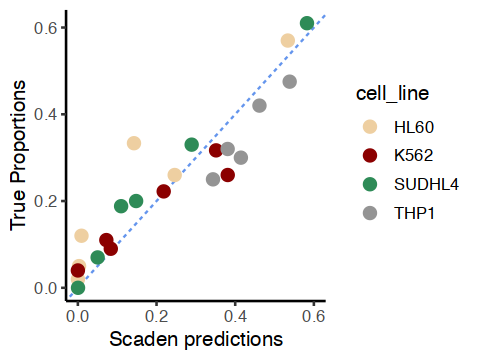

In [85]:
options(repr.plot.width=4, repr.plot.height=3)
df_msc = cbind(reshape2::melt(data.frame(true_prop)), 
               reshape2::melt(data.frame(scaden_prop)))
colnames(df_msc) = c('cell_line', 'true_prop', 'x', 'scaden_prop')
g = ggplot(df_msc) + geom_abline(slope=1, linetype = "dashed", colour='cornflowerblue') + 
    geom_point(aes(y=true_prop, x=scaden_prop, colour=cell_line), size=3) + theme_classic2() +              
    #stat_poly_eq(aes(y=true_prop, x=scaden_prop)) + 
    scale_color_manual(values=c('navajowhite2',  'darkred', 'seagreen', 'grey58')) +
    ylab('True Proportions') + xlab('Scaden predictions') + xlim(0,0.6) + xlim(0,0.6)
#pdf("results/climb_invitro/figs/invitro_Scaden_2d.pdf", width=4, height=3) ; g ; dev.off()
g

## Make statistics to compare correlation / errors 

### First we compare correlation using package 'cocor'

In [176]:
df_props = data.frame(true=as.vector(as.matrix(true_prop)), scaden=as.vector(as.matrix(scaden_prop)), 
                      tape=as.vector(as.matrix(tape_prop)), climb=as.vector(as.matrix(climb_prop)),
                      csx=as.vector(as.matrix(csx_prop)), bayesprism=as.vector(as.matrix(bayesprism_prop)),
                      music=as.vector(as.matrix(music_prop)), nnls=as.vector(as.matrix(nnls_prop)),
                      random=as.vector(as.matrix(rand_prop)), bisque=as.vector(as.matrix(bisque_prop)))

In [177]:
cocor_res.scaden =     cocor(~true + climb | true + scaden, df_props, alternative='greater')
cocor_res.tape =       cocor(~true + climb | true + tape, df_props, alternative='greater')
cocor_res.csx =        cocor(~true + climb | true + csx, df_props, alternative='greater')
cocor_res.bayesprism = cocor(~true + climb | true + bayesprism, df_props, alternative='greater')
cocor_res.music =      cocor(~true + climb | true + music, df_props, alternative='greater')
cocor_res.nnls =       cocor(~true + climb | true + nnls, df_props, alternative='greater')
cocor_res.bisque =     cocor(~true + climb | true + bisque, df_props, alternative='greater')
cocor_res.random =     cocor(~true + climb | true + random, df_props, alternative='greater')

In [179]:
df_signif = data.frame(pvalue=c(cocor_res.scaden@pearson1898$p.value, cocor_res.tape@pearson1898$p.value, 
                    cocor_res.csx@pearson1898$p.value, cocor_res.bayesprism@pearson1898$p.value,
                    cocor_res.music@pearson1898$p.value, cocor_res.nnls@pearson1898$p.value,
                    cocor_res.bisque@pearson1898$p.value, cocor_res.random@pearson1898$p.value),
           comparison=c('CLIMB_vs_Scaden', 'CLIMB_vs_TAPE', 'CLIMB_vs_CiberSortX', 'CLIMB_vs_BayesPrism',
                        'CLIMB_vs_MUSIC', 'CLIMB_vs_NNLS', 'CLIMB_vs_BisqueRNA', 'CLIMB_vs_Random'))

df_signif$signif = 'n.s'
df_signif$signif[df_signif$pvalue < 0.05] <- '*'
df_signif$signif[df_signif$pvalue < 0.01] <- '**'
df_signif$signif[df_signif$pvalue < 0.001] <- '***'
df_signif$signif[df_signif$pvalue < 0.0001] <- '****'

In [182]:
df_signif[rev(order(df_signif$pvalue)),]

,pvalue,comparison,signif
,<dbl>,<chr>,<chr>
1,2.752064e-01,CLIMB_vs_Scaden,n.s
4,1.958665e-02,CLIMB_vs_BayesPrism,*
5,1.162129e-02,CLIMB_vs_MUSIC,*
3,8.913817e-03,CLIMB_vs_CiberSortX,**
2,3.598769e-03,CLIMB_vs_TAPE,**
8,6.882446e-05,CLIMB_vs_Random,****
7,3.948777e-06,CLIMB_vs_BisqueRNA,****
6,1.432444e-06,CLIMB_vs_NNLS,****


## Plot the comparative results 

Use only per-sample metrics 

In [135]:
# Change the Metric by setting type.err to 1, 2, 3, or 4
generate_comp_plot <- function(type.err=1){
    #type.err , 1=pcor, 2=scor, 3=r_square, 4=rmse
    type.err.l = list('PCC', 'SCC', 'R2', 'RMSE')
    methods = c('MuSiC', 'NNLS', 'CLIMB', 'TAPE', 'Scaden', 'Bisque', 'Random', 'BayesPrism', 'CiberSortX')
    df_scor = data.frame(cbind(music.res[[type.err]], nnls.res[[type.err]], 
                               climb.res[[type.err]], tape.res[[type.err]], scaden.res[[type.err]],
                               bisque.res[[type.err]], rand.res[[type.err]], bayesprism.res[[type.err]], csx.res[[type.err]]))
    colnames(df_scor) = methods
    levels_ = colnames(df_scor)[rev(order(colMedians(as.matrix(df_scor), na.rm = T)))]
    if(type.err.l[[type.err]] == 'RMSE'){levels_ = rev(levels_)}
    df_scor_m = reshape2::melt(df_scor)
    df_scor_m$variable = factor(df_scor_m$variable, levels = levels_) 
    g_rows = ggplot(df_scor_m) + geom_boxplot(aes(x=variable, y=value, color=variable), outlier.shape = NA) + theme_classic() +
                geom_jitter(aes(x=variable, y=value, color=variable)) + theme_classic() +
                scale_color_manual(values=c('darkred','grey28','grey28','grey28','grey28','grey28','grey28','grey28','grey28','grey28')) + 
                theme(legend.position="none", axis.text.x = element_text(angle = 45, hjust=1.0, vjust=1.0)) +
                xlab('') + ylab(type.err.l[type.err]) #+ coord_flip() # ylab(expression(pa
    return(g_rows)
}

In [193]:
# PCC
g_pcc = generate_comp_plot(type.err=1) # 1=pcor, 2=scor, 3=r_square, 4=rmse

# SCC
g_scc = generate_comp_plot(type.err=2) # 1=pcor, 2=scor, 3=r_square, 4=rmse

# R-square
g_r2 = generate_comp_plot(type.err=3) # 1=pcor, 2=scor, 3=r_square, 4=rmse

# RMSE
g_rmse = generate_comp_plot(type.err=4) # 1=pcor, 2=scor, 3=r_square, 4=rmse

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



## Fig. 2X

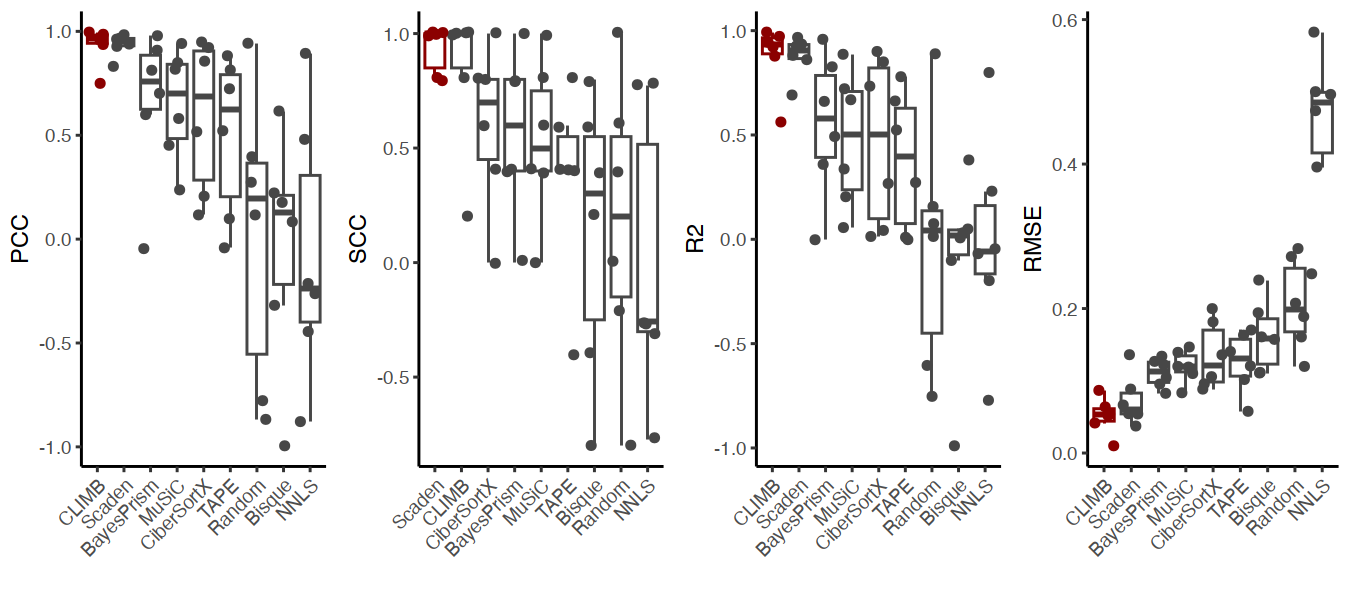

In [194]:
options(repr.plot.width=9, repr.plot.height=4)
g_arr = ggarrange(g_pcc, g_scc, g_r2, g_rmse, ncol = 4, nrow = 1)
g_arr

## Ranking method according to 4 metrics

In [147]:
all_rmse_cl = c(mean(rand.res[[4]]), mean(tape.res[[4]]), mean(nnls.res[[4]]), mean(bisque.res[[4]]),
             mean(music.res[[4]]), mean(scaden.res[[4]]), mean(bayesprism.res[[4]]),
             mean(csx.res[[4]]), mean(climb.res[[4]]))
all_pcc_cl = c(mean(rand.res[[1]]), mean(tape.res[[1]]), mean(nnls.res[[1]]), mean(bisque.res[[1]]),
             mean(music.res[[1]]), mean(scaden.res[[1]]), mean(bayesprism.res[[1]]),
             mean(csx.res[[1]]), mean(climb.res[[1]]))
all_scc_cl = c(mean(rand.res[[2]]), mean(tape.res[[2]]), mean(nnls.res[[2]]), mean(bisque.res[[2]]),
             mean(music.res[[2]]), mean(scaden.res[[2]]), mean(bayesprism.res[[2]]),
             mean(csx.res[[2]]), mean(climb.res[[2]]))
all_r2_cl = c(mean(rand.res[[3]]), mean(tape.res[[3]]), mean(nnls.res[[3]]), mean(bisque.res[[3]]),
             mean(music.res[[3]]), mean(scaden.res[[3]]), mean(bayesprism.res[[3]]),
             mean(csx.res[[3]]), mean(climb.res[[3]]))

In [189]:
df = data.frame(rank_rmse_cl=rank(all_rmse_cl),rank_pcc_cl=rank(-1*all_pcc_cl),
                rank_scc_cl=rank(-1*all_scc_cl), rank_r2_cl=rank(-1*all_r2_cl))

In [190]:
df$mean_rank = rowMeans(as.matrix(df))
df$sd_rank = rowSds(as.matrix(df))
rownames(df) = c('Random', 'TAPE', 'NNLS', 'BisqueRNA', 'MUSIC', 'Scaden', 'BayesPrism', 'CiberSortX', 'CLIMB')
df$method = rownames(df)
df$method = factor(df$method, levels=rev(df$method[order(df$mean_rank)]))

In [191]:
df

,rank_rmse_cl,rank_pcc_cl,rank_scc_cl,rank_r2_cl,mean_rank,sd_rank,method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Random,8,7,7,8,7.50,0.5000000,Random
TAPE,5,6,6,6,5.75,0.4330127,TAPE
NNLS,9,9,9,7,8.50,0.8660254,NNLS
BisqueRNA,7,8,8,9,8.00,0.7071068,BisqueRNA
MUSIC,4,4,5,4,4.25,0.4330127,MUSIC
Scaden,2,1,1,2,1.50,0.5000000,Scaden
BayesPrism,3,3,4,3,3.25,0.4330127,BayesPrism
CiberSortX,6,5,3,5,4.75,1.0897247,CiberSortX
CLIMB,1,2,2,1,1.50,0.5000000,CLIMB


## Fig. 2X

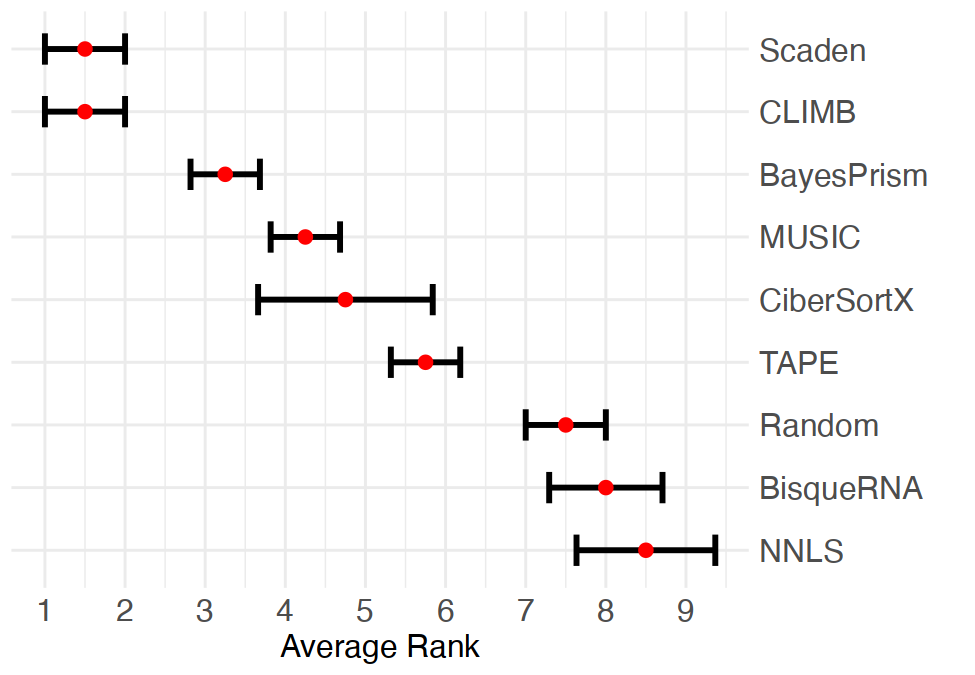

In [192]:
options(repr.plot.width=6.5, repr.plot.height=4.5)
g <- ggplot() + geom_errorbar(data=df, aes(y=method, xmin=mean_rank-sd_rank, xmax=mean_rank+sd_rank), width=0.5, size=1, color="black") +
    geom_point(data=df, aes(x=mean_rank, y=method), size=2.5, color='red') + scale_x_continuous(breaks=1:9) + 
    theme_minimal() + theme(axis.text=element_text(size = 15), text=element_text(size = 15)) + xlab('Average Rank') +
    ylab('') + scale_y_discrete(position = "right")
#pdf('results/climb_invitro/figs/average_Ranks_4metrics_3analysis.pdf', width=6.5, height=4.5) ; g ; dev.off()
g

In [156]:
wilcox.test(num(df['CLIMB',1:4]), num(df['BayesPrism',1:4]))

Warning message in wilcox.test.default(num(df["CLIMB", 1:4]), num(df["BayesPrism", :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  num(df["CLIMB", 1:4]) and num(df["BayesPrism", 1:4])
W = 0, p-value = 0.02465
alternative hypothesis: true location shift is not equal to 0


## Old version using also 'overall' and 'per cell line' metrics

In [126]:
# Change the Metric by setting type.err to 1, 2, 3, or 4
generate_comp_plot <- function(type.err=1){
    #type.err , 1=pcor, 2=scor, 3=r_square, 4=rmse
    type.err.l = list('PCC', 'SCC', 'R2', 'RMSE')
    methods = c('MuSiC', 'NNLS', 'CLIMB', 'TAPE', 'Scaden', 'Bisque', 'Random', 'BayesPrism', 'CiberSortX')
    df_scor = data.frame(cbind(music.res[[type.err]], nnls.res[[type.err]], 
                               climb.res[[type.err]], tape.res[[type.err]], scaden.res[[type.err]],
                               bisque.res[[type.err]], rand.res[[type.err]], bayesprism.res[[type.err]], csx.res[[type.err]]))
    colnames(df_scor) = methods
    levels_ = colnames(df_scor)[rev(order(colMeans(as.matrix(df_scor), na.rm = T)))]
    if(type.err.l[[type.err]] == 'RMSE'){levels_ = rev(levels_)}
    df_scor_m = reshape2::melt(df_scor)
    df_scor_m$variable = factor(df_scor_m$variable, levels = levels_) 

    options(repr.plot.width=3, repr.plot.height=3)
    g_rows = ggplot(df_scor_m) + geom_boxplot(aes(x=variable, y=value, color=variable), outlier.shape = NA) + theme_classic() +
                geom_jitter(aes(x=variable, y=value, color=variable)) + theme_classic() +
                scale_color_manual(values=c('darkred','grey28','grey28','grey28','grey28','grey28','grey28','grey28','grey28','grey28')) + 
                theme(legend.position="none", axis.text.x = element_text(angle = 45, hjust=1.0, vjust=1.0)) +
                xlab('') + ylab(type.err.l[type.err]) #+ coord_flip() # ylab(expression(paste(rho,' spearman'))) ylab(expression(R[2]))

    df_scor = data.frame(cbind(music.res[[type.err+4]], nnls.res[[type.err+4]], 
                               climb.res[[type.err+4]],  tape.res[[type.err+4]], scaden.res[[type.err+4]],
                               bisque.res[[type.err+4]], rand.res[[type.err+4]], bayesprism.res[[type.err+4]], csx.res[[type.err+4]]))
    colnames(df_scor) = methods 
    levels_ = colnames(df_scor)[rev(order(colMeans(as.matrix(df_scor), na.rm = T)))]
    if(type.err.l[[type.err]] == 'RMSE'){levels_ = rev(levels_)}
    df_scor_m = reshape2::melt(df_scor)
    df_scor_m$variable = factor(df_scor_m$variable, levels = levels_) 
    g_cols = ggplot(df_scor_m) + geom_boxplot(aes(x=variable, y=value, color=variable), outlier.shape = NA) + theme_classic() +
                geom_jitter(aes(x=variable, y=value, color=variable)) + theme_classic() +
                scale_color_manual(values=c('darkred','grey28','grey28','grey28','grey28','grey28','grey28','grey28','grey28','grey28')) + 
                theme(legend.position="none", axis.text.x = element_text(angle = 45, hjust=1.0, vjust=1.0)) +
                xlab('') + ylab(type.err.l[type.err]) #+ coord_flip() # paste(rho,' spearman')

    df_scor = data.frame(cbind(music.res[[type.err+8]], nnls.res[[type.err+8]], 
                               climb.res[[type.err+8]],  tape.res[[type.err+8]], scaden.res[[type.err+8]],
                               bisque.res[[type.err+8]], rand.res[[type.err+8]], bayesprism.res[[type.err+8]], csx.res[[type.err+8]]))
    colnames(df_scor) = methods 
    levels_ = colnames(df_scor)[rev(order(colMeans(as.matrix(df_scor), na.rm = T)))]
    if(type.err.l[[type.err]] == 'RMSE'){levels_ = rev(levels_)}
    df_scor_m = reshape2::melt(df_scor)
    df_scor_m$variable = factor(df_scor_m$variable, levels = levels_) 

    g_bar = ggplot(df_scor_m) + geom_bar(aes(x=variable, y=value, fill=variable), stat="identity") + theme_classic() +
                scale_fill_manual(values=c('darkred','grey28','grey28','grey28','grey28','grey28','grey28','grey28','grey28','grey28')) + 
                theme(legend.position="none", axis.text.x = element_text(angle = 45, hjust=1.0, vjust=1.0)) +
                xlab('') + ylab(type.err.l[type.err]) #+ coord_flip() #+ scale_y_continuous(breaks=seq(-0.2,1.1,0.1))
    g_arr = ggarrange(g_bar, g_rows, g_cols, ncol = 3, nrow = 1)
    return(g_arr)
}

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

Warning message:
“Removed 2 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


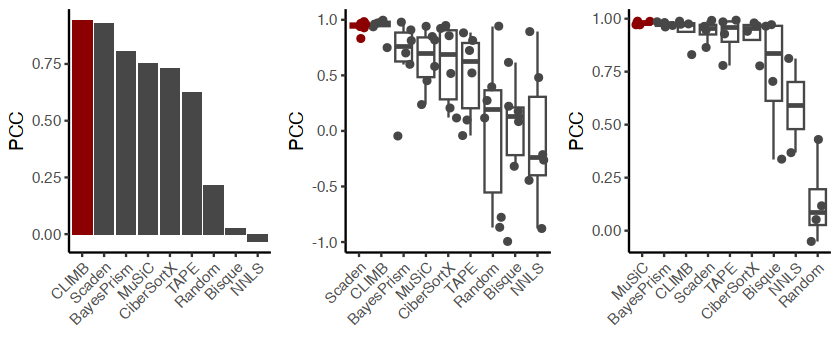

In [124]:
# PCC
g_arr = generate_comp_plot(type.err=1) # 1=pcor, 2=scor, 3=r_square, 4=rmse
options(repr.plot.width=7, repr.plot.height=3)
g_arr

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

Warning message:
“Removed 2 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


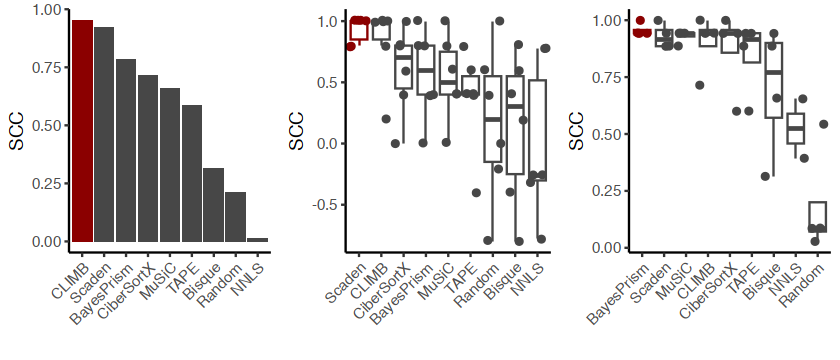

In [107]:
# SCC
g_arr = generate_comp_plot(type.err=2) # 1=pcor, 2=scor, 3=r_square, 4=rmse
options(repr.plot.width=7, repr.plot.height=3)
g_arr

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

Warning message:
“Removed 2 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


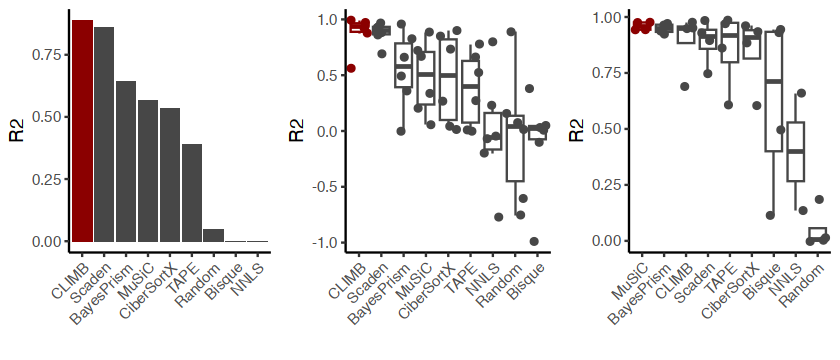

In [108]:
# R2
g_arr = generate_comp_plot(type.err=3) # 1=pcor, 2=scor, 3=r_square, 4=rmse
options(repr.plot.width=7, repr.plot.height=3)
g_arr

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



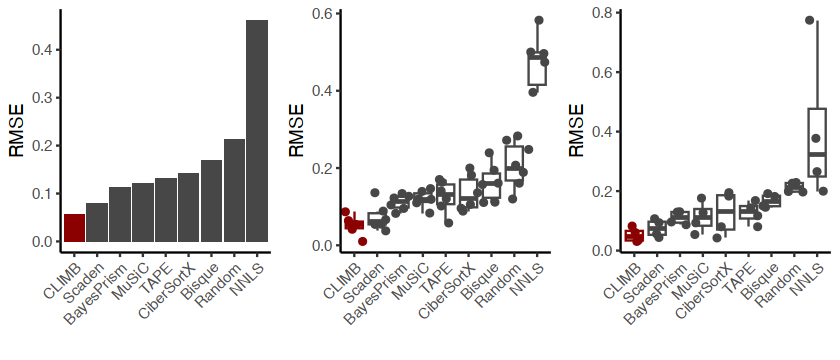

In [127]:
# RMSE
g_arr = generate_comp_plot(type.err=4) # 1=pcor, 2=scor, 3=r_square, 4=rmse
options(repr.plot.width=7, repr.plot.height=3)
g_arr

## MISC

In [31]:
num(table(sc.es$cellType)) / num(length(sc.es$cellType))

[1] 0.2433817 0.2813834 0.2352690 0.2399658

In [32]:
names(table(sc.es$cellType))

[1] "HL60"   "K562"   "SUDHL4" "THP1"

In [4]:
cov_mat = cov(exprs(sc.es))

In [6]:
celltypes = unique(sc.es$cellType)

max_cov_ct = list()
for(k in 1:length(celltypes)){
    ct = celltypes[k]
    max_cov_ct[[k]] = min(cov_mat[sc.es$cellType == ct,sc.es$cellType == ct])
}

names(max_cov_ct) = celltypes
max_cov_ct

$K562
[1] 0.2208072

$THP1
[1] 0.7052391

$SUDHL4
[1] 0.2665056

$HL60
[1] 0.1320525

In [7]:
min(cov_mat)

[1] 0.05035018

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



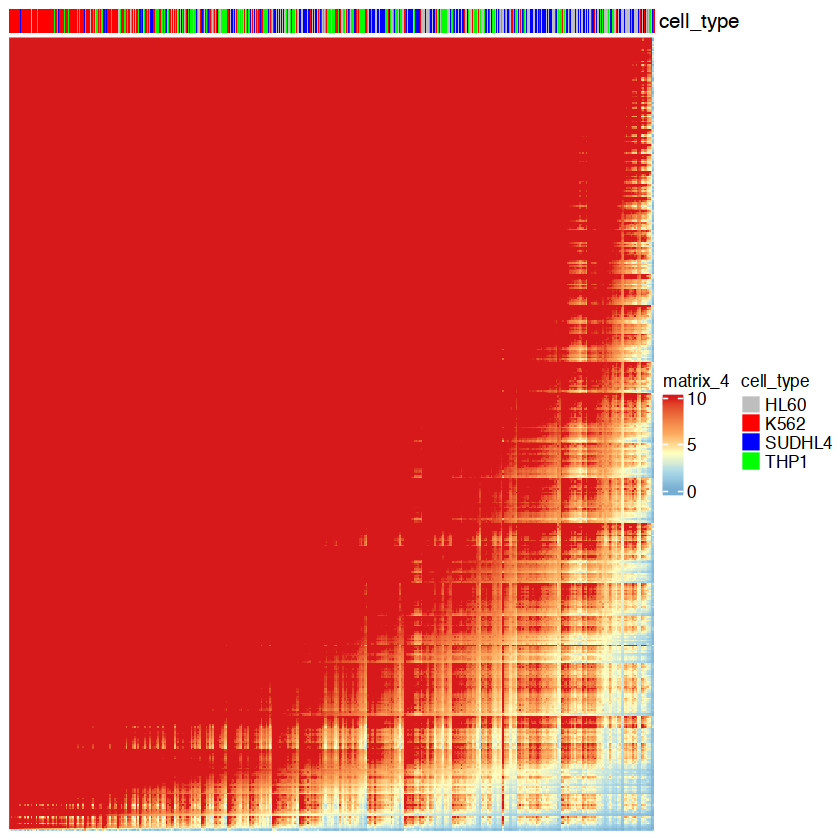

In [15]:
col_panel = c('#74add1', "#abd9e9", '#ffffbf','#fdae61', '#d7191c')
col_fun = colorRamp2(c(0,2,4,6,10), col_panel)
ha = HeatmapAnnotation(cell_type = as.character(sc.es$cellType),
    col = list(cell_type = c("K562" = "red", "THP1" = "green", "SUDHL4" = "blue", 'HL60'='grey')))
Heatmap(cov_mat, col=col_fun, top_annotation = ha,
        show_column_names=F, show_row_names=F, show_column_dend=F, show_row_dend=F)

In [13]:
as.character(sc.es$cellType)

character(0)